# Sentiment Analysis Using RNN

### 1. Importing packages on your system

In [136]:
# import libraries
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,LSTM , GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import  Embedding
from tensorflow.keras.models import Sequential
import tensorflow as tf
import itertools

import seaborn as sns
sns.set()

In [137]:
tf.__version__

'2.4.1'

In [138]:
import warnings
warnings.filterwarnings('ignore')

### 2. Load data from disk

In [139]:
df = pd.read_csv(r"C:/Users/gi-129785/Desktop/MyPracticeData/Data/IMDB Dataset.csv")

In [140]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [141]:
df.shape

(50000, 2)

In [142]:
# split the data set into train and test

train = df.iloc[:40000]
test = df.iloc[40000:]

# write to disk 
train.to_csv("C:/Users/gi-129785/Desktop/MyPracticeData/Data/movie_reviews_train.csv", index=False)
test.to_csv("C:/Users/gi-129785/Desktop/MyPracticeData/Data/movie_reviews_test.csv", index=False)

In [143]:
# read data
df_train = pd.read_csv("C:/Users/gi-129785/Desktop/MyPracticeData/Data/movie_reviews_train.csv")
df_test =  pd.read_csv("C:/Users/gi-129785/Desktop/MyPracticeData/Data/movie_reviews_test.csv")

In [144]:
# check the shape of the dataframe
print(df_train.shape) # this dataset contain 40000 records and 2 columns for training
print(df_test.shape) # this dataset contain 10000 records and 2 columns for testing

(40000, 2)
(10000, 2)


In [145]:
df_train.columns

Index(['review', 'sentiment'], dtype='object')

In [146]:
df_train["review"][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [147]:
df_train.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [148]:
df_train.tail()

,review,sentiment
39995,This was a marvelously funny comedy with a gre...,positive
39996,There is no plot. There are no central charact...,positive
39997,This show is awesome! I love all the actors! I...,positive
39998,The fact that this movie has been entitled to ...,negative
39999,I have to confess that I am severely disappoin...,negative


In [149]:
df_test.head()

,review,sentiment
0,First off I want to say that I lean liberal on...,negative
1,I was excited to see a sitcom that would hopef...,negative
2,When you look at the cover and read stuff abou...,negative
3,"Like many others, I counted on the appearance ...",negative
4,"This movie was on t.v the other day, and I did...",negative


In [150]:
df_test.tail()

,review,sentiment
9995,I thought this movie did a down right good job...,positive
9996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
9997,I am a Catholic taught in parochial elementary...,negative
9998,I'm going to have to disagree with the previou...,negative
9999,No one expects the Star Trek movies to be high...,negative


### 3. Data Preprocessing and Visualization

<AxesSubplot:xlabel='sentiment', ylabel='count'>

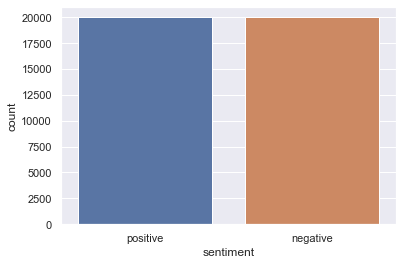

In [151]:
import seaborn as sns
sns.countplot(df_train["sentiment"])

In [152]:
Neg = round(df_train["sentiment"].value_counts()[1]/len(df_train) * 100, 2)
Pos = round(df_train["sentiment"].value_counts()[0]/len(df_train) * 100, 2)


print('This train_dataset contain {}% Negative Sentiment tweet'.format(Neg))
print('This train_dataset contain {}% Positive Sentiment tweet'.format(Pos))

This train_dataset contain 49.98% Negative Sentiment tweet
This train_dataset contain 50.02% Positive Sentiment tweet


In [153]:
# create a label columns using manual label encoding
lab = {"positive":1,"negative":0}
df_train['label']= df_train["sentiment"].map(lab)
df_train.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [154]:
def clean_review(text): 
    ''' 
    Utility function to clean review text by removing links, special characters 
    using simple regex statements. 
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split()).lower()

# clean tweet 
df_train["clean_review"] = df_train["review"].apply(lambda text : clean_review(text))

In [155]:
df_train.head()

,review,sentiment,label,clean_review
0,One of the other reviewers has mentioned that ...,positive,1,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,1,a wonderful little production br br the filmin...
2,I thought this was a wonderful way to spend ti...,positive,1,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,0,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter mattei s love in the time of money is a...


In [156]:
# check for missing value 
df_train.isnull().sum()

review          0
sentiment       0
label           0
clean_review    0
dtype: int64

In [157]:
# drop missing rows
# df_train = df_train.dropna()
# df_train.isnull().sum()

In [158]:
# convert training dataset into tensorflow dataset format

train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(df_train["clean_review"].values, tf.string),
            tf.cast(df_train['label'].values, tf.int32)
        )
    )
)


In [159]:
train_dataset

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int32)>

In [160]:
# print first five record from train dataset
for example, label in train_dataset.take(5):
    print("--"*50)
    print("example : ", example.numpy())
    print()
    print("label: ", label.numpy())

----------------------------------------------------------------------------------------------------
example :  b'one of the other reviewers has mentioned that after watching just 1 oz episode you ll be hooked they are right as this is exactly what happened with me br br the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word br br it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never f

In [161]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [162]:
# create batches of the dataset

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# now every batch will have 64 samples

In [163]:
# print first batch from train dataset

for example, label in train_dataset.take(1):
    print("example : ", example.numpy())
    print("-----------------------")
    print("label: ", label.numpy())
    print("-----------------------")
    print("total len: ", len(label.numpy()))

example :  [b'the original assault on precinct 13 is gritty witty and perhaps most importantly short this remake is mercilessly padded out and talky worse yet the african american hero of the first movie is here replaced with handsome white boy ethan hawke which makes this assault less progressive than the 1970s one god how i miss john carpenter and his improbable plot line and his weird sense of humor i even miss his b list actors who are leagues better than hawke and company br br i can t say i care for the new villains in this version they stretch what little credibility the story ever had to the limit the female characters are useless the criminals are all generic hoods and gabriel byrne gives another of his bored performances the music s all wrong too it s bland action stuff that actually detracts from the tension simply awful'
 b'i saw this movie on late night tv out of buffalo about 30 years ago and i m dying to see it again one more time before i well you know the interaction b

### 4. Creating your training and validation splits

In [164]:
# create validation dataset
val_dataset = train_dataset.take(100) 
train_dataset = train_dataset.skip(100)

# select first 100 batch from train dataset for validation data
# each bacth will contain 64 samples and skip first 100 batch from train dataset

### 5. Create the text encoder 

the raw text data needs to be processed before it can be used in a model. The simplest way to process text for training is using the textvectorization layer this layer has many capbiliites.

In [165]:
# Create the layer, and pass the dataset text to the layer's .adapt method

VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [166]:
# create vocabulary of words
vocab = np.array(encoder.get_vocabulary())

# print top 20 vocab
vocab[0:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'br', 'it', 'in',
       'i', 'this', 'that', 's', 'was', 'as', 'movie', 'for', 'with'],
      dtype='<U14')

In [167]:
len(vocab)

1000

In [168]:
encoded_example = encoder("This is a nice pen!").numpy()
encoded_example

array([ 12,   7,   4, 335,   1], dtype=int64)

In [169]:
encoder.get_vocabulary()[334]

'3'

In [170]:
vocab

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'br', 'it', 'in',
       'i', 'this', 'that', 's', 'was', 'as', 'movie', 'for', 'with',
       'but', 'film', 'you', 'on', 't', 'not', 'he', 'are', 'his', 'have',
       'be', 'one', 'all', 'at', 'they', 'by', 'an', 'who', 'so', 'from',
       'like', 'there', 'or', 'just', 'her', 'about', 'out', 'if', 'has',
       'what', 'some', 'good', 'can', 'more', 'very', 'when', 'she', 'up',
       'time', 'no', 'even', 'my', 'would', 'which', 'only', 'really',
       'see', 'their', 'story', 'had', 'me', 'well', 'we', 'were', 'much',
       'than', 'bad', 'people', 'get', 'great', 'been', 'other', 'do',
       'also', 'will', 'because', 'into', 'how', 'don', 'him', 'first',
       'most', 'made', 'its', 'then', 'make', 'them', 'way', 'could',
       'too', 'movies', 'after', 'any', 'characters', 'think', 'watch',
       'character', 'films', 'two', 'many', 'seen', 'love', 'plot',
       'being', 'never', 'acting', 'life', 'did', 'show', 

with default settings, the process is not completely reversible. two reason for this
1. the dfualt value for preprocessing.textvectorization standrdize argument is "lower_and_strip_punctuation"
2. the limited vocabulary size and lack of character-based fallback result in some unknown tokens.

### 6. Defining your RNN model architecture

In [171]:
# create RNN model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True), # word2vec
    tf.keras.layers.SimpleRNN(64),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1) # tf.keras.layers.Dense(3, activation="softmax")
])

# note: if you use activation =sigmoid you will get the probability score for model not the negative scores
# but if you use by defualt value then you will get negative and positive value

1. this model can be build as a tf.keras.Sequential.
2. the first layer is the encoder, which converts the text to a sequence of token indices.
3. after the encoder is an embedding layer. an embedding layer stores one vector per word. when called it converts the sequences
of word indices to sequences of vectors. theses vecotrs are trainable. after training (on enough data), words with similar meanings ofter have similar vectors
4. a recurrent neurel network (RNN) process sequences input by iterating through the elements. RNN pass the outputs from timestep to their input on the next timestep
- The tf.keras.layers.bidirectioinal wrapper can aslo be used with an rnn layer. this propagates the input forward and backwards through the rnn layer and then concatenates the final output
- the main advanatage to a bidirectional rnn is that the signal from the beginning of the input dosent need to be process all the way through very timestep to affect the output
- the main disadvantage of a bidirectional rnn is that you cant efficiently stream predictions as words are being added to the end 

5. after the rnn has converted the sequences to a single vector the tow layers.dense do some final processing, and convert from this vector representation to a single logit as the classification output.

In [172]:
# pass sample input

sample_text = ("the movie was cool. the animatioin and the graphics werer out of this world. i would recommend this movie")

predictions = model.predict(np.array([sample_text]))
print(predictions)

[[0.12159195]]


In [173]:
# play with models (uncomment one one layer at time and check the output)
model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=5, mask_zero=True),
     tf.keras.layers.SimpleRNN(5),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5))
     tf.keras.layers.Dense(5, activation="relu"),
     tf.keras.layers.Dense(1)
])

sample_text = ("the movie was cool")
predictions = model2(np.array([sample_text]))
print(predictions)

tf.Tensor([[-0.05442395]], shape=(1, 1), dtype=float32)


### 7. Compiling your RNN model

In [174]:
# compile the model

# for binary classification
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


# for 3 level 
# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer=tf.keras.optimizers.Adam(1e-4),
#               metrics=['accuracy'])

In [175]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 76,481
Trainable params: 76,481
Non-trainable params: 0
_________________________________________________________________


### 8. Training your model on your training data

In [176]:
EPOCHS = 15

results =model.fit(train_dataset,
                  epochs=EPOCHS,
                  validation_data=val_dataset)

Epoch 1/15
525/525 [==============================] - 148s 277ms/step - loss: 0.6890 - accuracy: 0.5018 - val_loss: 0.6187 - val_accuracy: 0.5473
Epoch 2/15
525/525 [==============================] - 157s 300ms/step - loss: 0.5602 - accuracy: 0.6793 - val_loss: 0.3757 - val_accuracy: 0.8359
Epoch 3/15
525/525 [==============================] - 151s 287ms/step - loss: 0.3638 - accuracy: 0.8417 - val_loss: 0.3048 - val_accuracy: 0.8686
Epoch 4/15
525/525 [==============================] - 154s 293ms/step - loss: 0.3180 - accuracy: 0.8640 - val_loss: 0.3164 - val_accuracy: 0.8736
Epoch 5/15
525/525 [==============================] - 152s 290ms/step - loss: 0.3109 - accuracy: 0.8642 - val_loss: 0.2980 - val_accuracy: 0.8678
Epoch 6/15
525/525 [==============================] - 153s 292ms/step - loss: 0.2956 - accuracy: 0.8698 - val_loss: 0.2850 - val_accuracy: 0.8702
Epoch 7/15
525/525 [==============================] - 152s 290ms/step - loss: 0.2842 - accuracy: 0.8785 - val_loss: 0.2999 -

### 9. Evaluating your model on your test data

<AxesSubplot:xlabel='sentiment', ylabel='count'>

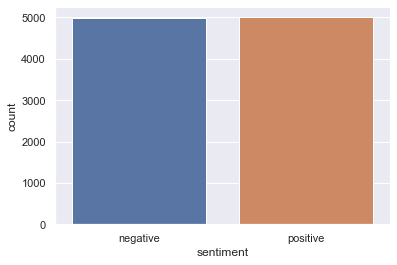

In [177]:
sns.countplot(df_test["sentiment"])

In [178]:
Neg = round(df_test["sentiment"].value_counts()[1]/len(df_test) * 100, 2)
Pos = round(df_test["sentiment"].value_counts()[0]/len(df_test) * 100, 2)


print('This train_dataset contain {}% Neutral Sentiment tweet'.format(Neg))
print('This train_dataset contain {}% Positive Sentiment tweet'.format(Pos))

This train_dataset contain 49.93% Neutral Sentiment tweet
This train_dataset contain 50.07% Positive Sentiment tweet


In [179]:
# clean text
df_test["clean_review"] = df_test["review"].apply(lambda text : clean_review(text))

# create a label columns using manual label encoding
lab = {"positive":1,"negative":0}
df_test['label']= df_test["sentiment"].map(lab)
df_test.head(10)

,review,sentiment,clean_review,label
0,First off I want to say that I lean liberal on...,negative,first off i want to say that i lean liberal on...,0
1,I was excited to see a sitcom that would hopef...,negative,i was excited to see a sitcom that would hopef...,0
2,When you look at the cover and read stuff abou...,negative,when you look at the cover and read stuff abou...,0
3,"Like many others, I counted on the appearance ...",negative,like many others i counted on the appearance o...,0
4,"This movie was on t.v the other day, and I did...",negative,this movie was on t v the other day and i didn...,0
5,Hickory Dickory Dock was a good Poirot mystery...,positive,hickory dickory dock was a good poirot mystery...,1
6,"""One Crazy Summer"" is the funniest, craziest (...",positive,one crazy summer is the funniest craziest not ...,1
7,Low-budget schlockmeister Herschell Gordon Lew...,negative,low budget schlockmeister herschell gordon lew...,0
8,this was absolutely the most tragic pile of ci...,negative,this was absolutely the most tragic pile of ci...,0
9,I have never understood the appeal of this sho...,negative,i have never understood the appeal of this sho...,0


In [180]:
df_test = df_test[["clean_review", "label"]]
df_test.head()

,clean_review,label
0,first off i want to say that i lean liberal on...,0
1,i was excited to see a sitcom that would hopef...,0
2,when you look at the cover and read stuff abou...,0
3,like many others i counted on the appearance o...,0
4,this movie was on t v the other day and i didn...,0


In [181]:
# check missing values 
df_test.isna().sum()

clean_review    0
label           0
dtype: int64

In [182]:
# convert testing dataset into tensorflow dataset format

test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(df_test["clean_review"].values, tf.string),
            tf.cast(df_test['label'].values, tf.int32)
        )
    )
)
# create batches in test dataset
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [183]:
for example, label in test_dataset.take(1):
    print("example : ", example.numpy())
    print("-----------------------")
    print("label: ", label.numpy())
    print("-----------------------")
    print("total len: ", len(label.numpy()))

example :  [b'first off i want to say that i lean liberal on the political scale and i found the movie offensive i managed to watch the whole doggone disgrace of a film this movie brings a low to original ideas yes it was original thus my 2 stars instead of 1 are our film writers that uncreative that they can only come up with this acting was horrible and the characters were unlikeable for the most part the lead lady in the story had no good qualities at all they made her bf into some sort of a bad guy and i did not see that at all maybe i missed something i do not know he was the most down to earth relevant character in the movie i did not shell out any money for this garbage i almost wish peta would come to the rescue of this awful offensive movie and form a protest disgusting thats all i have to say anymore'
 b'i was excited to see a sitcom that would hopefully represent indian candians but i found this show to be not funny at all the producers and cast are probably happy to get bot

In [184]:
test_loss, test_acc = model.evaluate(test_dataset)

157/157 [==============================] - 13s 81ms/step - loss: 0.3336 - accuracy: 0.8580


In [185]:
print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_acc))

Test Loss: 0.3336085379123688
Test Accuracy: 0.8579999804496765


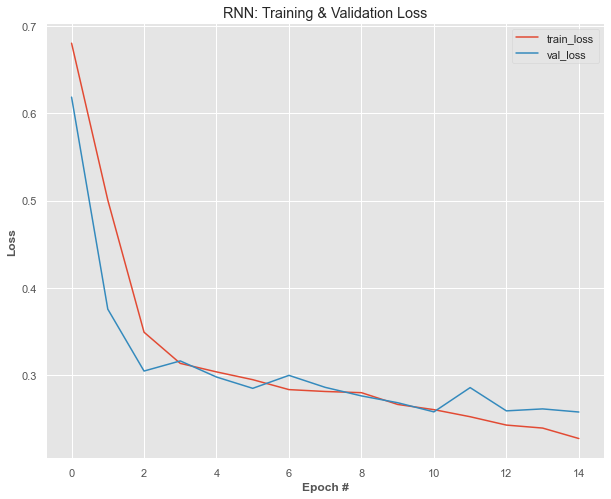

In [186]:
# plot the training and validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, results.history["loss"], label="train_loss")
plt.plot(N, results.history["val_loss"], label="val_loss")
plt.title("RNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

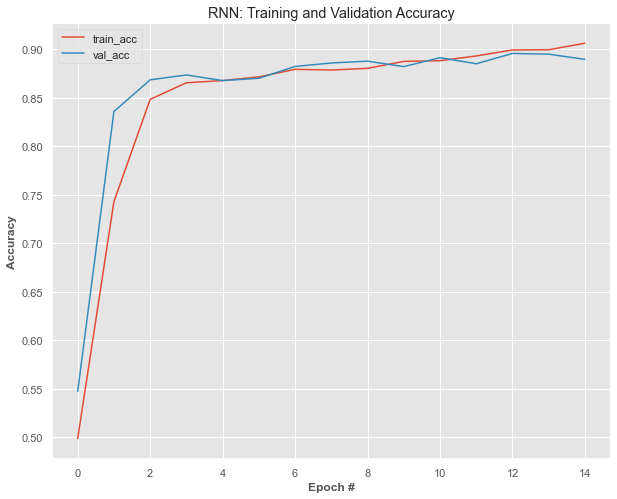

In [187]:
# plot the training and validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, results.history["accuracy"], label="train_acc")
plt.plot(N, results.history["val_accuracy"], label="val_acc")
plt.title("RNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

In [188]:
# predict on a sample text 

sample_text = ("The movie was not Good, I would not recommend this movie.")

prediction = model.predict(np.array([sample_text]))
print(prediction)

if prediction[0][0] >= 0:
    print("positive")
else:
    print("negative")

[[-1.423577]]
negative


### 10. Saving the model

In [189]:
# save the model to disk
print("[INFO] serializing network...")
model.save("model/sentiment_RNN_15epochs.model", save_format="H5")

[INFO] serializing network...
INFO:tensorflow:Assets written to: model/sentiment_RNN_15epochs.model\assets


In [190]:
from tensorflow.keras.models import load_model
new_model = load_model("model/sentiment_RNN_15epochs.model")
print("[INFO] model loaded succesfully..")

[INFO] model loaded succesfully..


In [191]:
new_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, None)              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 76,481
Trainable params: 76,481
Non-trainable params: 0
_________________________________________________________________


### 11. Making predictions for unseen data

In [192]:
# check missing value 
df_test.isnull().sum()

clean_review    0
label           0
dtype: int64

In [193]:
df_test.head()

,clean_review,label
0,first off i want to say that i lean liberal on...,0
1,i was excited to see a sitcom that would hopef...,0
2,when you look at the cover and read stuff abou...,0
3,like many others i counted on the appearance o...,0
4,this movie was on t v the other day and i didn...,0


In [194]:
# prediction on unseen data
y_pred = model.predict(np.array(df_test["clean_review"]))

In [195]:
y_pred[:10] # confidence for each class

array([[-5.397298  ],
       [-2.9195707 ],
       [ 0.90318733],
       [-6.117399  ],
       [-1.7362643 ],
       [ 5.6022024 ],
       [ 3.0012772 ],
       [-5.873928  ],
       [-2.695051  ],
       [-0.69141096]], dtype=float32)

In [196]:
# convert conf to 1 if +conf else 0
y_pred_bool = []
for conf in y_pred:
    if conf[0] >= 0:
        y_pred_bool.append(1)
    else:
        y_pred_bool.append(0)

df_test["pred"] = y_pred_bool

In [197]:
df_test.head()

,clean_review,label,pred
0,first off i want to say that i lean liberal on...,0,0
1,i was excited to see a sitcom that would hopef...,0,0
2,when you look at the cover and read stuff abou...,0,1
3,like many others i counted on the appearance o...,0,0
4,this movie was on t v the other day and i didn...,0,0


### 12. confusion matrix

In [198]:
def plot_confusion_metrix(y_true, y_pred,classes,
                         normalize=False,
                         title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    """
    Objective
    ----------
    plot confussion matrix, classification report and accuracy score
    
    parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.

    y_pred : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.
    
    classes : list
        List of labels to index the matrix
        
    title : title for matrix
    cmap : colormap for matrix 
    
    returns 
    ----------
   all accruacy matrix 
    """
    
    
    cm = confusion_matrix(y_true,y_pred)
    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix, Without Normalisation")

    
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=35)
    plt.yticks(tick_marks,classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() /2.
    
    for i , j in itertools.product(range(cm.shape[0]), range(cm.shape[0])):
        plt.text(j, i, format(cm[i,j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # plt.tight_layout()
    
    plt.show()
    
    print("-----------------------------------------------------")
    print('Classification report')
    print(classification_report(y_true,y_pred))
    
    print("-----------------------------------------------------")
    acc= accuracy_score(y_true,y_pred)
    print("Accuracy of the model: ", acc)

Confusion Matrix, Without Normalisation


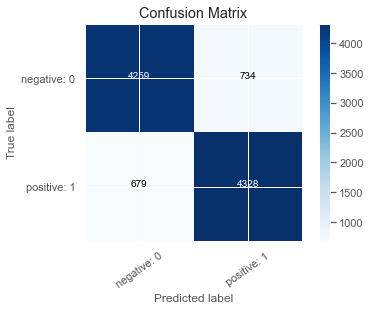

-----------------------------------------------------
Classification report
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      4993
           1       0.85      0.86      0.86      5007

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

-----------------------------------------------------
Accuracy of the model:  0.8587


In [199]:
plot_confusion_metrix(df_test["label"], df_test["pred"],classes=["negative: 0","positive: 1"])

### 13. final submission

In [200]:
def label(a):
    if a==0:
        return "Negative"
    elif a==1:
        return "Positive"

In [201]:
df_test["pred"] = df_test["pred"].apply(lambda a : label(a))
df_test["label"] = df_test["label"].apply(lambda a : label(a))

In [202]:
df_test.head()

,clean_review,label,pred
0,first off i want to say that i lean liberal on...,Negative,Negative
1,i was excited to see a sitcom that would hopef...,Negative,Negative
2,when you look at the cover and read stuff abou...,Negative,Positive
3,like many others i counted on the appearance o...,Negative,Negative
4,this movie was on t v the other day and i didn...,Negative,Negative


### 14. Future scope

return_sequence : - false: it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). this is the default used in previous model - true: the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape(batch_size, timesteps, output_features))

the intresting thing about using an rnn with return sequences=true is that the output still has 3axes like the input so it can be passed to another rnn layer like this.